In [175]:
import os
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import yaml

sns.set_style("darkgrid")
palette = sns.color_palette()
pd.options.mode.copy_on_write = True
scripts_dir = os.path.abspath(os.path.join(os.getcwd(), "../scripts"))
sys.path.append(scripts_dir)
workflows_dir = os.path.abspath(os.path.join(os.getcwd(), ".."))
sys.path.append(workflows_dir)

# pretty print
pretty_print = {"string": "STRING",
      "gseapy": "GSEApy",
      "clusterProfiler": "ClusterProfiler",
      "neg_signed_logpval": "signed logPValue",
      "logFC": "logFC"}

# Define params

- `input_file`: Path (relative to project root) to a csv file containing a table with gene names and ranking metric(s). Input files should be put in the `resources` folder.
  
- `project_name`: A string to tag output files. Results will be saved in `results/{project_name}/some_filename.{project_name}.csv`

- `metrics`: A list of strings specifying columns in the input table that are used to rank the genes.

In [272]:
#### User-defined variables ####

input_file = "resources/Carmen/edger.paired.qlf.lfc0.csv"
project_name = "Carmen.paired.QLF"

input_file = "resources/Chiara/edger.qlf.lfc0.KO_WT.p1.csv"
project_name = "Chiara.QLF.KO_WT"

input_file = "resources/Chiara/edger.qlf.lfc0.SA_WT.p1.csv"
project_name = "Chiara.QLF.SA_WT"

input_file = "resources/Chiara/edger.qlf.lfc0.SD_WT.p1.csv"
project_name = "Chiara.QLF.SD_WT"

input_file = "resources/TCGA/BRCA.edgerqlf.lfc0.csv"
project_name = "BRCA.QLF"

input_file = "resources/TCGA/THCA.edgerqlf.lfc0.csv"
project_name = "THCA.QLF"

input_file = "resources/TCGA/KIRC.edgerqlf.lfc0.csv"
project_name = "KIRC.QLF"

# input_file = "resources/TCGA/LIHC.edgerqlf.lfc0.csv"
# project_name = "LIHC.QLF"


metrics = ['logFC', 'neg_signed_logpval']
libraries = ["KEGG","GO"]
tools = ["clusterProfiler","gseapy","string"]

# ClusterProfiler

keytype = "ENSEMBL"
organismKEGG = "hsa"

In [290]:
#### User-defined variables ####

input_file = "resources/Liana/deg.edger.lrt.batch.unm_0.6.clean.clExc7_DL.thresh.0.2.2024-01-22-17-42.P90.p19rc.csv"
project_name = "met.Exc7_DL.P90.p19rc"


# input_file = "resources/Liana/deg.edger.lrt.batch.unm_0.6.clean.clInh_Sncg.thresh.0.2.2024-01-19-11-47.P14.p19rc.csv"
# project_name = "met.Inh_Sncg.P14.p19rc"


metrics = ['logFC', 'neg_signed_logpval']
libraries = ["KEGG","GO"]
tools = ["clusterProfiler","gseapy","string"]

# ClusterProfiler

keytype = "SYMBOL"
organismKEGG = "mmu"

## Create config.yaml file

In [291]:
# Create configuration dictionary
config_data = {
    'input_file': input_file,
    'project_name': project_name,
    'metrics': metrics,
    'keytype': keytype,
    'organismKEGG': organismKEGG,
    'libraries': libraries,
    'tools': tools
}

# Write to config.yaml
config_filename = "../../config/config.yaml"
with open(config_filename, 'w') as file:
    yaml.dump(config_data, file, default_flow_style=False)

print(f"Configuration file '{config_filename}' created successfully!")

savepath = f"../../results/{project_name}/"
figpath = f"../../results/{project_name}/figures/"
!mkdir -p $figpath

Configuration file '../../config/config.yaml' created successfully!


# Inspect/modify input

This space can be used to calculate further ranking metrics that are missing in the input table. As an example, we read the output table from edgeR, calculate $-\mathrm{sign}(\log_2\mathrm{FC})\times\log_{10}(p\mathrm{-value})$, and add this as a new column to the table.

**Careful:** Updating input files after jobs have been run will re-run the jobs the next time Snakemake is run. To prevent this, you can use `--touch` to update the timestamps of previously generated output files:

`snakemake --touch --cores 1`

In [94]:
df = pd.read_csv(f"../../{input_file}", index_col=0)
df["neg_signed_logpval"] = -np.sign(df["logFC"]) * np.log10(df["PValue"])
display(df.head())
sig = df[df["FDR"]<0.01]
print(len(sig))
#df.to_csv(f"../../{input_file}")

,logFC,logCPM,F,PValue,FDR,neg_signed_logpval
ENSG00000142945,3.398807,1.899451,379.509248,1.005409e-25,1.569142e-21,24.997657
ENSG00000117724,3.451918,3.149666,360.827830,3.226705e-25,2.298770e-21,24.491241
ENSG00000089685,3.619598,2.943914,355.931124,4.418729e-25,2.298770e-21,24.354703
ENSG00000100526,3.503020,1.644097,339.105973,1.340552e-24,5.230500e-21,23.872716
ENSG00000145708,-6.682806,5.138373,315.400970,6.963530e-24,1.745142e-20,-23.157171


7987


## Correlations

Inspect correlations between the two different ranking metrics (e.g. logFC and signed pvalue)

In [ ]:
rank1 = "logFC"
rank2 = "neg_signed_logpval"

fig, ax = plt.subplots(1, 2, figsize=(10,5))

### Pearson correlation

correlation = df[rank1].corr(df[rank2], method='pearson')
sns.regplot(x=df[rank1], y=df["neg_signed_logpval"], ax=ax[0], scatter_kws={'alpha':0.1}, line_kws={"color":palette[3]})
ax[0].set_title(f"Pearson: {correlation:.2f}")

ax[0].set(xlabel=rank1)
ax[0].set(ylabel="-sign(logFC)*log10(p-value)")

### Spearman rank correlation

df['rank1'] = df[rank1].rank(method='average')
df['rank2'] = df[rank2].rank(method='average')
rank_correlation = df['rank1'].corr(df['rank2'], method='spearman')

sns.regplot(x=df['rank1'] ,y=df['rank2'], ax=ax[1], scatter_kws={'alpha':0.01}, line_kws={"color":palette[3]})
ax[1].set_title(f"Spearman: {rank_correlation:.2f}")
fig.tight_layout()

ax[1].set(xlabel="logFC [Rank]")
ax[1].set(ylabel="-sign(logFC)*log10(p-value) [Rank]")

# Run Snakemake

Run the following command in project root directory:

`snakemake --use-conda --cores 1` (adjust number of cores as needed)

In [ ]:
# import subprocess

# cores = 1
# command = f"snakemake -s ../Snakefile --configfile ../../config/config.yaml --use-conda --cores {cores}"
# subprocess.run(command, shell=True, check=True)

# Inspect results

## Load results

In [292]:
import pickle
import matplotlib
from scripts.plots import npg_palette

npg = npg_palette()
output_files = glob.glob(f"{savepath}/syn.*[tc]sv")
print(f"Found {len(output_files)} output files:\n",*[o+"\n" for o in output_files])

Found 16 output files:
 ../../results/met.Exc7_DL.P90.p19rc/syn.combined.GO.met.Exc7_DL.P90.p19rc.csv
 ../../results/met.Exc7_DL.P90.p19rc/syn.combined.KEGG.met.Exc7_DL.P90.p19rc.csv
 ../../results/met.Exc7_DL.P90.p19rc/syn.clusterProfiler.neg_signed_logpval.GO.met.Exc7_DL.P90.p19rc.csv
 ../../results/met.Exc7_DL.P90.p19rc/syn.gseapy.logFC.KEGG.met.Exc7_DL.P90.p19rc.csv
 ../../results/met.Exc7_DL.P90.p19rc/syn.clusterProfiler.logFC.KEGG.met.Exc7_DL.P90.p19rc.csv
 ../../results/met.Exc7_DL.P90.p19rc/syn.string.logFC.KEGG.met.Exc7_DL.P90.p19rc.csv
 ../../results/met.Exc7_DL.P90.p19rc/syn.gseapy.neg_signed_logpval.KEGG.met.Exc7_DL.P90.p19rc.csv
 ../../results/met.Exc7_DL.P90.p19rc/syn.gseapy.neg_signed_logpval.GO.met.Exc7_DL.P90.p19rc.csv
 ../../results/met.Exc7_DL.P90.p19rc/syn.string.logFC.met.Exc7_DL.P90.p19rc.tsv
 ../../results/met.Exc7_DL.P90.p19rc/syn.string.neg_signed_logpval.KEGG.met.Exc7_DL.P90.p19rc.csv
 ../../results/met.Exc7_DL.P90.p19rc/syn.gseapy.logFC.GO.met.Exc7_DL.P90.p19

In [293]:
summary_dict = {lib: dict() for lib in libraries}
for lib in libraries:
    summary_df = pd.read_csv(f"{savepath}/syn.combined.{lib}.{project_name}.csv", index_col=0, header=[0,1,2])
    summary_df.sort_values(by=("Combined","nan","Combined FDR"))
    summary_dict[lib]["summary_df"] = summary_df

summary_df = summary_dict[libraries[1]]["summary_df"]
print(libraries[0], len(summary_df))
summary_df.head()

KEGG 3134


Tool          clusterProfiler                                        \
Metric     neg_signed_logpval                                         
Value         enrichmentScore        pvalue        qvalue Direction   
GO:0050804          -0.457943  5.235685e-09  9.877850e-07      Down   
GO:0006396           0.485575  1.369684e-08  2.239553e-06        Up   
GO:0000398           0.596003  2.273146e-07  1.858396e-05        Up   
GO:0006397           0.516015  1.999995e-07  1.858396e-05        Up   
GO:0034330          -0.396687  2.204013e-07  1.858396e-05      Down   

Tool                                                                 gseapy  \
Metric               logFC                               neg_signed_logpval   
Value      enrichmentScore    pvalue    qvalue Direction    enrichmentScore   
GO:0050804       -0.394040  0.000007  0.000821      Down          -0.404045   
GO:0006396        0.439577  0.000008  0.000821        Up           0.565910   
GO:0000398        0.564692  0.000002  0.000400        Up           0.711948   
GO:0006397        0.457959  0.000035  0.002659        Up           0.715907   
GO:0034330       -0.370673  0.000003  0.000448      Down          -0.522166   

Tool                  ...             string                                  \
Metric                ... neg_signed_logpval           logFC                   
Value         pvalue  ...          Direction enrichmentScore  pvalue  qvalue   
GO:0050804  0.014000  ...               Down       -0.475816  0.0124  0.0124   
GO:0006396  0.000000  ...                 Up        0.435475  0.0007  0.0007   
GO:0000398  0.000000  ...                 Up        0.766333  0.0061  0.0061   
GO:0006397  0.000000  ...                 Up        0.445967  0.0015  0.0015   
GO:0034330  0.117769  ...               Down       -0.532494  0.0570  0.0570   

Tool                             Combined                                     \
Metric                                nan                                      
Value      Direction enrichmentScore Mean enrichmentScore SD Combined pvalue   
GO:0050804      Down            -0.480937           0.129894    2.944889e-04   
GO:0006396        Up             0.576394           0.227105    6.045835e-14   
GO:0000398        Up             0.828183           0.404883    1.116306e-13   
GO:0006397        Up             0.639655           0.235085    1.814081e-13   
GO:0034330      Down            -0.501722           0.106564    1.519389e-03   

Tool                                                               nan  
Metric                                                             nan  
Value       Combined FDR                                   Description  
GO:0050804  6.626000e-04  modulation of chemical synaptic transmission  
GO:0006396  7.685567e-13                                RNA processing  
GO:0000398  7.685567e-13                mRNA splicing, via spliceosome  
GO:0006397  8.163365e-13                               mRNA processing  
GO:0034330  2.734901e-03                    cell junction organization  

[5 rows x 29 columns]

In [294]:
# directionality
# summary_df[("string","logFC","Direction")].value_counts()
# qv = summary_df.drop(["Combined","nan"], axis=1, level=0)
# qv = qv.xs("enrichmentScore", level=2, axis=1)
# qv.dropna(axis=0).sum()

In [295]:
# from scripts import explore_results
# import importlib
# importlib.reload(explore_results)

from scripts.explore_results import get_sig_dict, create_intersection_depth_df
from scripts.utils import pickler

qval = 0.05

for lib in summary_dict:
    print(lib)
    summary_df = summary_dict[lib]["summary_df"]
    sig_dict = get_sig_dict(summary_df, tools, metrics, qval=qval, verbose=True)
    summary_dict[lib]["depth_df"] = create_intersection_depth_df(sig_dict)    

# Store results in dictionary for meta-analysis
pickler(summary_dict, f"{savepath}/{project_name}.summary_dict.txt")

KEGG
clusterProfiler logFC Terms tested: 186 Significant: 0
clusterProfiler neg_signed_logpval Terms tested: 186 Significant: 28
gseapy logFC Terms tested: 158 Significant: 0
gseapy neg_signed_logpval Terms tested: 158 Significant: 32
string logFC Terms tested: 1 Significant: 1
string neg_signed_logpval Terms tested: 2 Significant: 1
GO
clusterProfiler logFC Terms tested: 3064 Significant: 152
clusterProfiler neg_signed_logpval Terms tested: 3064 Significant: 382
gseapy logFC Terms tested: 898 Significant: 8
gseapy neg_signed_logpval Terms tested: 898 Significant: 10
string logFC Terms tested: 50 Significant: 12
string neg_signed_logpval Terms tested: 126 Significant: 23


## Intersection depth

We count the number of unique analysis configuations (methods, rankings) each significant term appears in. We designate this as the *intersection depth* of a term. A depth of $N$ means that the corresponding enrichment term is significant in exactly $N$ configurations.

In [296]:
# sns.set_style("whitegrid")

# fig, axes = plt.subplots(1, 2, figsize=(10,3))

# for ax, lib in zip(axes,summary_dict):
#     depth_df = summary_dict[lib]["depth_df"]
#     h = sns.histplot(depth_df['Depth'], bins=depth_df['Depth'].max() - depth_df['Depth'].min() + 1, 
#                  discrete=True, ax=ax, alpha=1)
#     h.bar_label(h.containers[0])
#     ax.set(title=lib, xlabel="Depth", ylabel="Terms")
#     ax.set_xticks(range(depth_df['Depth'].min(), depth_df['Depth'].max() + 1))
#     ax.grid(axis='x')

# fig.tight_layout()
# fig.savefig(f"{figpath}/intersection_depth.{project_name}.pdf")

In [297]:
# sns.set_style("whitegrid")

# fig, axes = plt.subplots(1, 2, figsize=(10,5))

# for ax, lib in zip(axes,summary_dict):
#     summary_df = summary_dict[lib]["summary_df"]
#     qv = summary_df.drop(["Combined","nan"], axis=1, level=0)
#     qv = qv.xs("qvalue", level=2, axis=1)
#     qv = qv.replace(np.nan,1)
#     qv = qv < qval

#     qqv=qv.sum().reset_index()
#     qqv.replace({"Tool": pretty_print, "Metric": pretty_print}, inplace=True)
#     qqv.index = qqv["Tool"] + "\n" + qqv["Metric"]
#     qqv = qqv.drop(["Tool","Metric"], axis=1)
#     qqv = qqv.sort_values(by=qqv.columns[0], ascending=False)

#     b = sns.barplot(x=qqv.index, y=qqv.iloc[:, 0], ax=ax, alpha=1)
#     for i in b.containers:
#         b.bar_label(i,)
#     ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=45, ha='right')
#     ax.set(title=lib, ylabel="Terms", xlabel=None)

# fig.tight_layout()
# fig.savefig(f"{figpath}/number_sig_terms.{project_name}.pdf")

/tmp/ipykernel_6676/2366318645.py:39: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  b = sns.barplot(data=qqv, x=qqv.index, y=qqv.iloc[:, 0], ax=ax, alpha=1, hue = 'hue', palette=palette, hue_order=hue_order)
/tmp/ipykernel_6676/2366318645.py:39: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  b = sns.barplot(data=qqv, x=qqv.index, y=qqv.iloc[:, 0], ax=ax, alpha=1, hue = 'hue', palette=palette, hue_order=hue_order)


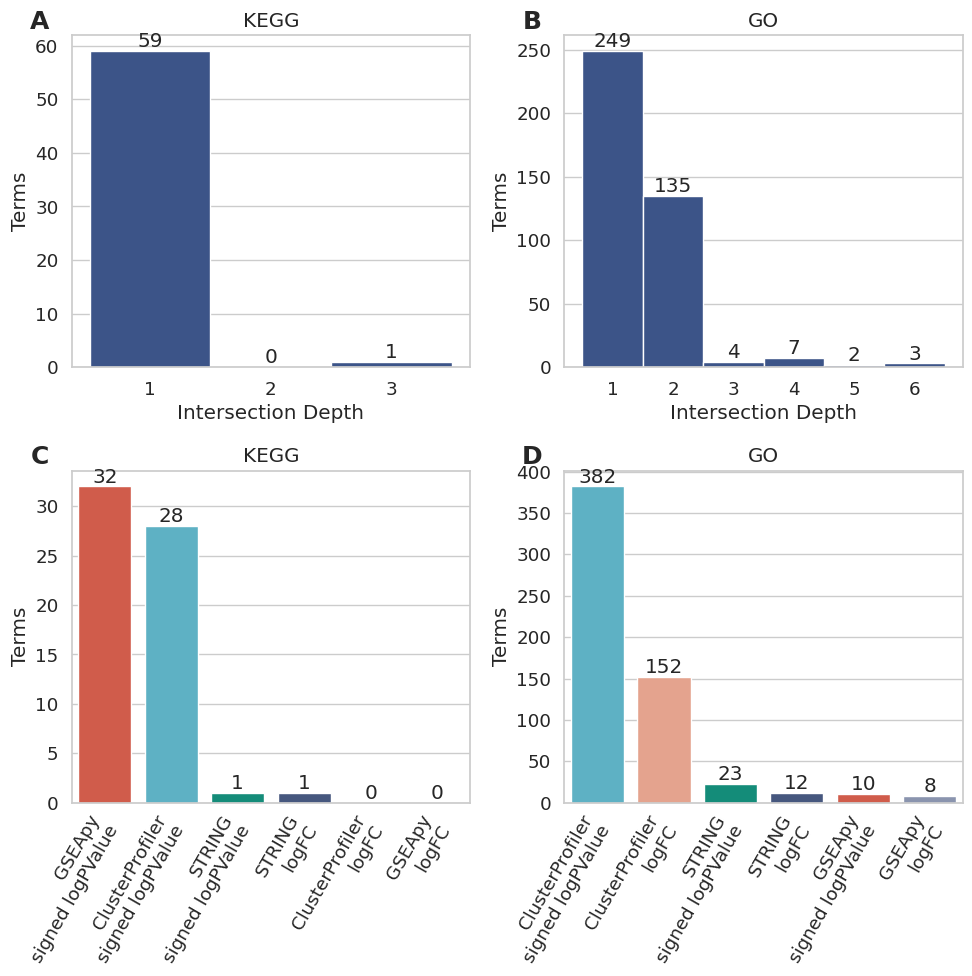

In [298]:
palette = npg

sns.set(font_scale=1.2)
sns.set_style("whitegrid")

fig, axes = plt.subplots(2, 2, figsize=(10,10))
axes = axes.flatten()

### Intersection depth

for ax, lib in zip(axes[:2],libraries):
    depth_df = summary_dict[lib]["depth_df"]
    h = sns.histplot(depth_df['Depth'], bins=depth_df['Depth'].max() - depth_df['Depth'].min() + 1, 
                discrete=True, ax=ax, alpha=1, color=npg[3])
    h.bar_label(h.containers[0])
    ax.set(title=lib, xlabel="Intersection Depth", ylabel="Terms")
    ax.set_xticks(range(depth_df['Depth'].min(), depth_df['Depth'].max() + 1))
    ax.grid(axis='x')        
    
### Number of terms

for ax, lib in zip(axes[2:], libraries):
    summary_df = summary_dict[lib]["summary_df"]
    qv = summary_df.drop(["Combined","nan"], axis=1, level=0)
    qv = qv.xs("qvalue", level=2, axis=1)
    qv = qv.replace(np.nan,1)
    qv = qv < qval

    qqv=qv.sum().reset_index()
    qqv.replace({"Tool": pretty_print, "Metric": pretty_print}, inplace=True)
    qqv.index = qqv["Tool"] + "\n" + qqv["Metric"]
    qqv = qqv.drop(["Tool","Metric"], axis=1)
    qqv = qqv.sort_values(by=qqv.columns[0], ascending=False)

    if ax == axes[2]:
        hue_order = {qqv.index[i]: npg[i] for i in range(len(qqv))}

    qqv["hue"] = qqv.index
    b = sns.barplot(data=qqv, x=qqv.index, y=qqv.iloc[:, 0], ax=ax, alpha=1, hue = 'hue', palette=palette, hue_order=hue_order)
    for i in b.containers:
        b.bar_label(i,)
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=60, ha='right')
    ax.set(title=lib, ylabel="Terms", xlabel=None)
    
    # apply offset transform to all x ticklabels.
    offset = matplotlib.transforms.ScaledTranslation(12/72., 3/72., fig.dpi_scale_trans)
    for label in ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)
for i in range(len(axes)):
    axes[i].annotate(chr(ord('A')+i), xy=(-0.08, 1.04), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=18)

fig.tight_layout()
fig.savefig(f"{figpath}/bars.{project_name}.pdf")

## Venn diagrams

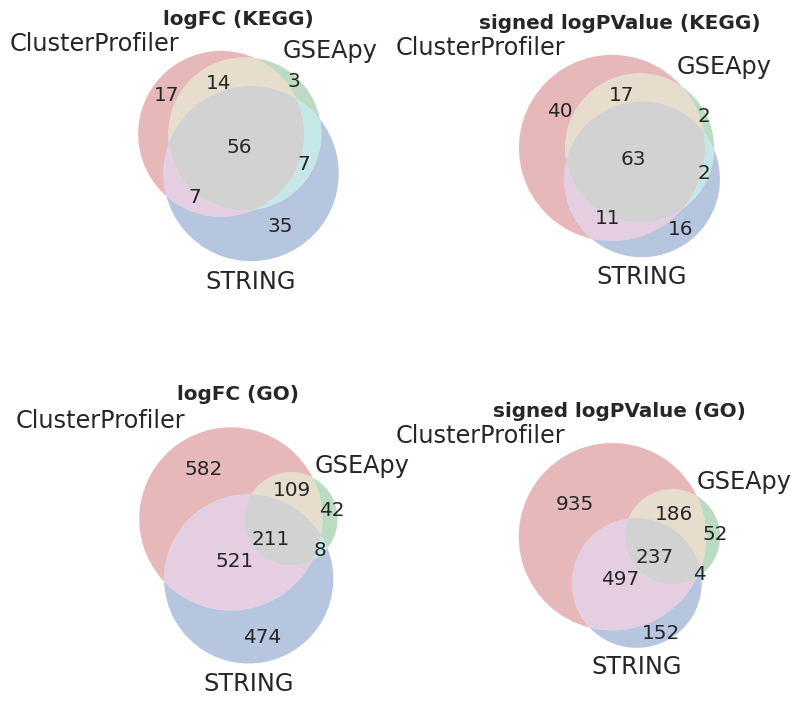

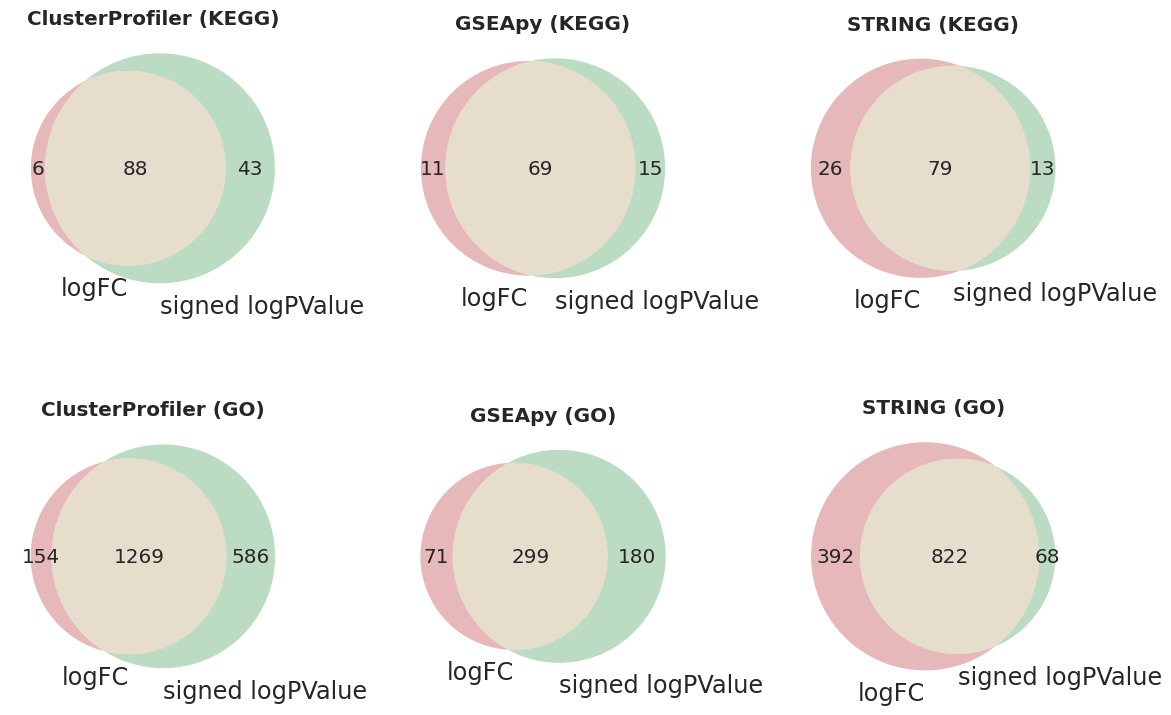

In [102]:
from scripts.plots import plot_venn

fig, ax = plt.subplots(2, 2, figsize=(8,8))

for i, lib in enumerate(libraries):
    summary_df = summary_dict[lib]["summary_df"]
    sig_dict = get_sig_dict(summary_df, tools, metrics, qval=0.05)
    for j, metric in enumerate(metrics):
        plot_venn(sig_dict, tools, metric, ax[i][j], pretty_print)
        ax[i][j].set_title(f"{pretty_print[metric]} ({lib})", fontweight='bold')

fig.tight_layout()
fig.savefig(f"{figpath}/venn.methodcomp.{project_name}.pdf")


fig, ax = plt.subplots(2, 3, figsize=(12,8))

for i, lib in enumerate(libraries):
    summary_df = summary_dict[lib]["summary_df"]
    sig_dict = get_sig_dict(summary_df, tools, metrics, qval=0.05)
    for j, tool in enumerate(tools):
        plot_venn(sig_dict, tool, metrics, ax[i][j], pretty_print)
        ax[i][j].set_title(f"{pretty_print[tool]} ({lib})", fontweight='bold')

fig.tight_layout()
fig.savefig(f"{figpath}/venn.metriccomp.{project_name}.pdf")

## UpSet plots

Useful for visualizing set intersection with more than 3 sets. 

https://upsetplot.readthedocs.io/en/stable/index.html

/home/peter/miniforge3/envs/SynEnrich/lib/python3.12/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/peter/miniforge3/envs/SynEnrich/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  style

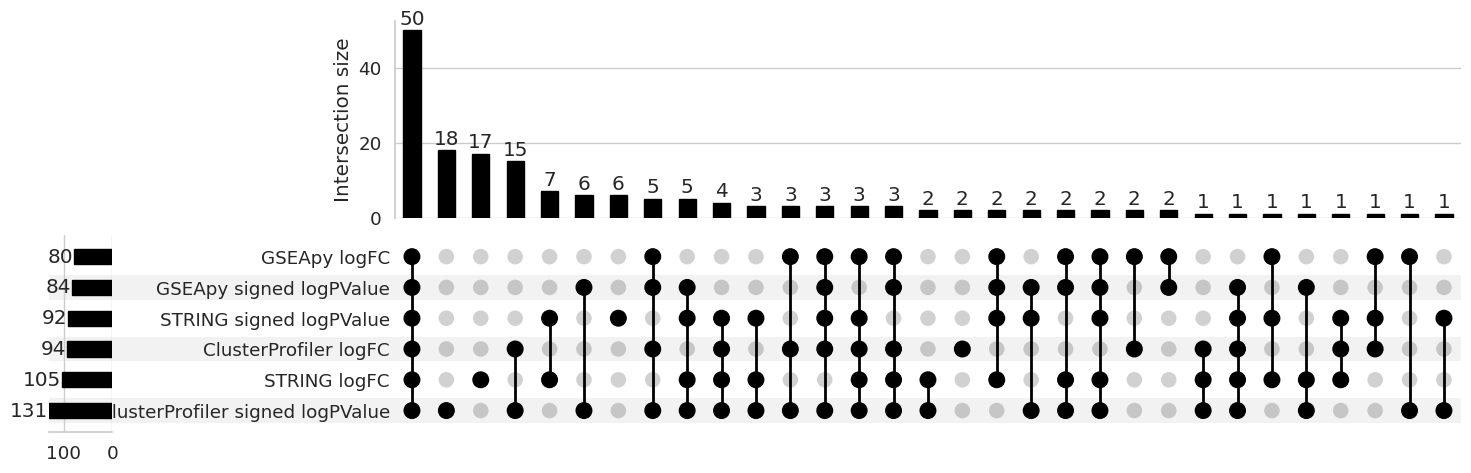

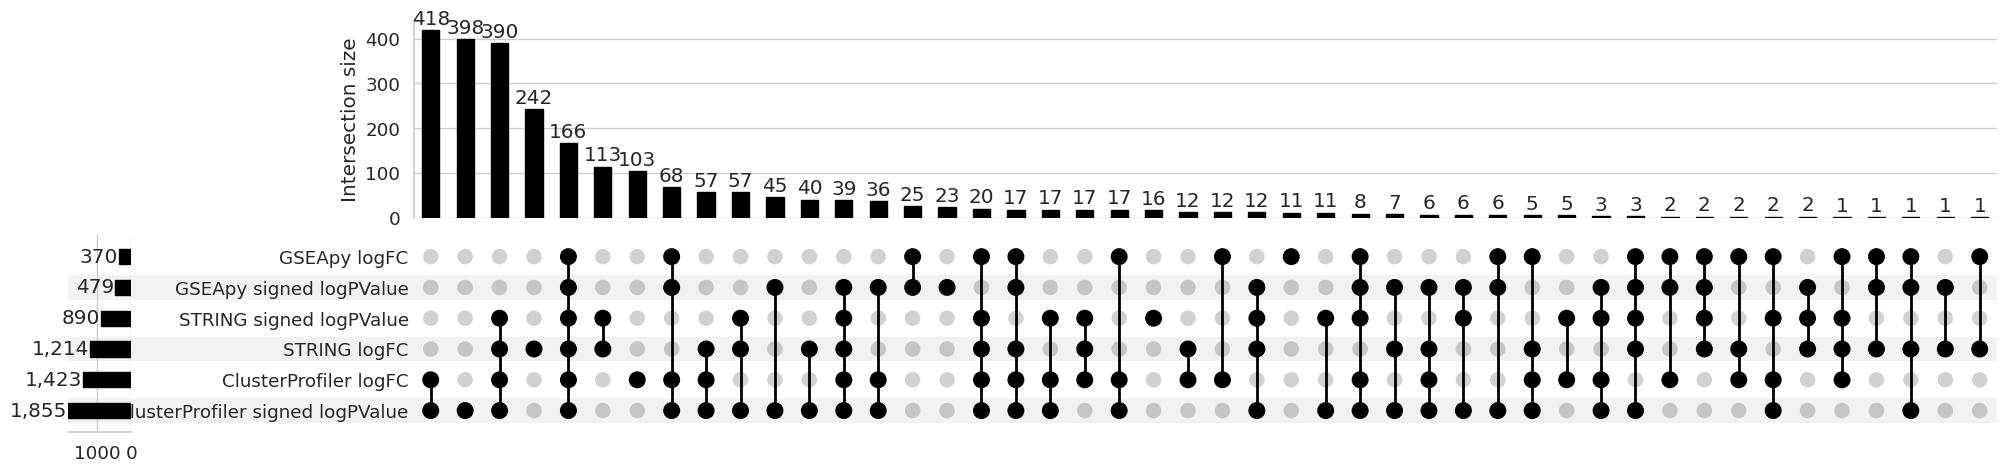

In [103]:
from matplotlib import pyplot
from upsetplot import from_memberships
from upsetplot import UpSet

for lib in libraries:

    depth_df = summary_dict[lib]["depth_df"]
    memberships = depth_df["Factors"]
    memberships_list = [categories.split(" | ") for categories in memberships.values]
    upset_ready = from_memberships(memberships_list)
    upset_ready.index.names = [" ".join([pretty_print[i] for i in u.split(".")]) for u in upset_ready.index.names] # pretty print

    pd.options.mode.copy_on_write = False
    UpSet(upset_ready, subset_size="count", sort_by="cardinality", show_counts="{:,}").plot()
    pd.options.mode.copy_on_write = True
    pyplot.savefig(f"{figpath}/upset.{lib}.{project_name}.pdf")

# Meta-analysis

Compare multiple datasets

In [420]:
import pickle
from scripts.plots import npg_palette

npg = npg_palette()

#project_names = ["BRCA.LRT", "Carmen.unpaired.LRT", "Chiara.KO_WT", "Chiara.SA_WT", "met.Exc7_DL.P90.p19rc"]
project_names = ["THCA.QLF","BRCA.QLF", "KIRC.QLF", "LIHC.QLF",
                 "Carmen.paired.QLF", 
                 "Chiara.QLF.KO_WT", "Chiara.QLF.SA_WT", "Chiara.QLF.SD_WT",
                 "met.Exc7_DL.P90.p19rc", "met.Inh_Sncg.P14.p19rc"]

pretty_datanames = {"BRCA.QLF":"TCGA.BRCA.N-T",
                    "THCA.QLF":"TCGA.THCA.N-T",
                    "KIRC.QLF":"TCGA.KIRC.N-T",
                    "LIHC.QLF":"TCGA.LIHC.N-T",
                    "met.Exc7_DL.P90.p19rc": "sn.Exc7.P90.WT-SA",
                    "met.Inh_Sncg.P14.p19rc": "sn.Inh.Sncg.P14.WT-SA",
                    "Chiara.QLF.KO_WT":"Ser1016.WT-KO",
                    "Chiara.QLF.SA_WT":"Ser1016.WT-SA",
                    "Chiara.QLF.SD_WT":"Ser1016.WT-SD",
                    "Carmen.paired.QLF":"CHK2.WT-KO"}

meta_dict = dict()
for project in project_names:
    try:
        with open(f"../../results/{project}/{project}.summary_dict.txt", "rb") as f:
            meta_dict[project] = pickle.load(f)
    except FileNotFoundError:
        print(f"Project not found: {project}")

npg

[(0.9019607843137255, 0.29411764705882354, 0.20784313725490197),
 (0.30196078431372547, 0.7333333333333333, 0.8352941176470589),
 (0.0, 0.6274509803921569, 0.5294117647058824),
 (0.23529411764705882, 0.32941176470588235, 0.5333333333333333),
 (0.9529411764705882, 0.6078431372549019, 0.4980392156862745),
 (0.5176470588235295, 0.5686274509803921, 0.7058823529411765),
 (0.5686274509803921, 0.8196078431372549, 0.7607843137254902),
 (0.8627450980392157, 0.0, 0.0),
 (0.49411764705882355, 0.3803921568627451, 0.2823529411764706),
 (0.6901960784313725, 0.611764705882353, 0.5215686274509804)]

In [423]:
meta_depth_dict = dict()

for lib in libraries:
    meta_depth_df = []
    for project in meta_dict:
        depth_df_p = meta_dict[project][lib]["depth_df"]
        depth_df_p["Project"] = project
        depth_df_p.replace({"Project":pretty_datanames}, inplace=True)
        meta_depth_df.append(depth_df_p)

    meta_depth_df = pd.concat(meta_depth_df)
    meta_depth_dict[lib] = meta_depth_df

In [425]:
meta_summary_dict = dict()

for lib in libraries:
    meta_summary_df = []
    for project in meta_dict:
        df = meta_dict[project][lib]["summary_df"]
        df.index = df.index + "." + project # needed for venn
        meta_summary_df.append(df)

    meta_summary_df = pd.concat(meta_summary_df)
    meta_summary_dict[lib] = meta_summary_df

/tmp/ipykernel_6676/1978693487.py:63: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  b = sns.barplot(data=qqv, x=qqv.index, y=qqv.iloc[:, 0], ax=ax, alpha=1, hue = 'hue', palette=palette, hue_order=hue_order)
/tmp/ipykernel_6676/1978693487.py:63: UserWarning: The palette list has more values (10) than needed (6), which may not be intended.
  b = sns.barplot(data=qqv, x=qqv.index, y=qqv.iloc[:, 0], ax=ax, alpha=1, hue = 'hue', palette=palette, hue_order=hue_order)


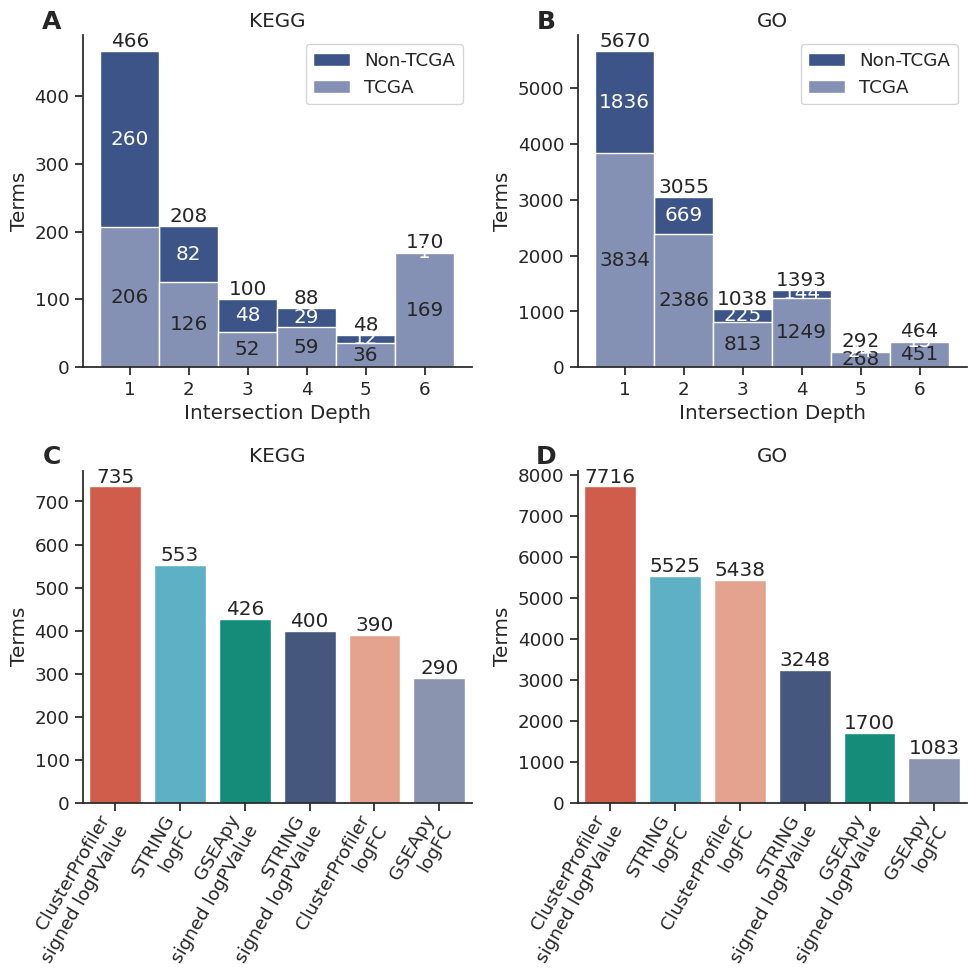

In [428]:
import matplotlib

palette = npg

sns.set(font_scale=1.2)
#sns.set_style("whitegrid")
sns.set_style("ticks")

fig, axes = plt.subplots(2, 2, figsize=(10,10))
axes = axes.flatten()

### Intersection depth

for ax, lib in zip(axes[:2],meta_depth_dict):
    sns.despine()
    depth_df = meta_depth_dict[lib]
    h = sns.histplot(depth_df['Depth'], bins=depth_df['Depth'].max() - depth_df['Depth'].min() + 1, 
                discrete=True, ax=ax, alpha=1, color=npg[3], label="Non-TCGA")
    h.bar_label(h.containers[0])
    ax.set(title=lib, xlabel="Intersection Depth", ylabel="Terms")
    ax.set_xticks(range(depth_df['Depth'].min(), depth_df['Depth'].max() + 1))
    ax.grid(axis='x')

    ### plot TCGA only on top
    TCGA = depth_df[depth_df["Project"].str.startswith("TCGA")]
    sns.histplot(TCGA['Depth'], bins=depth_df['Depth'].max() - depth_df['Depth'].min() + 1, 
                discrete=True, ax=ax, alpha=1, color=npg[5], label="TCGA")
    
    ### label bars    
    nonTCGA = depth_df[~depth_df["Project"].str.startswith("TCGA")]
    nonTCGA_counts = nonTCGA['Depth'].value_counts().sort_index()
    TCGA_counts = TCGA['Depth'].value_counts().sort_index()
    for i in range(depth_df["Depth"].max()):
        ax.text(s=TCGA_counts.iloc[i], x=i+1,y=TCGA_counts.iloc[i]/2,  va='center',ha='center')
        ax.text(s=nonTCGA_counts.iloc[i], x=i+1,y=TCGA_counts.iloc[i]+nonTCGA_counts.iloc[i]/2,  va='center',ha='center',color="white")

    ax.legend(loc="best")
    ax.grid(False)

    if ax == axes[0]:
        pass#ax.set_ylim(0,349)

### Number of terms

for ax, lib in zip(axes[2:], meta_summary_dict):
    sns.despine()
    summary_df = meta_summary_dict[lib]
    qv = summary_df.drop(["Combined","nan"], axis=1, level=0)
    qv = qv.xs("qvalue", level=2, axis=1)
    qv = qv.replace(np.nan,1)
    qv = qv < qval

    qqv=qv.sum().reset_index()
    qqv.replace({"Tool": pretty_print, "Metric": pretty_print}, inplace=True)
    qqv.index = qqv["Tool"] + "\n" + qqv["Metric"]
    qqv = qqv.drop(["Tool","Metric"], axis=1)
    qqv = qqv.sort_values(by=qqv.columns[0], ascending=False)

    if ax == axes[2]:
        hue_order = {qqv.index[i]: npg[i] for i in range(len(qqv))}

    qqv["hue"] = qqv.index
    b = sns.barplot(data=qqv, x=qqv.index, y=qqv.iloc[:, 0], ax=ax, alpha=1, hue = 'hue', palette=palette, hue_order=hue_order)
    for i in b.containers:
        b.bar_label(i,)
    ax.set_xticks(ax.get_xticks(), ax.get_xticklabels(), rotation=60, ha='right')
    ax.set(title=lib, ylabel="Terms", xlabel=None)

    # apply offset transform to all x ticklabels.
    offset = matplotlib.transforms.ScaledTranslation(12/72., 3/72., fig.dpi_scale_trans)
    for label in ax.xaxis.get_majorticklabels():
        label.set_transform(label.get_transform() + offset)
        
for i in range(len(axes)):
    axes[i].annotate(chr(ord('A')+i), xy=(-0.08, 1.04), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=18)

fig.tight_layout()
fig.savefig("../../results/meta/bars.meta.pdf")

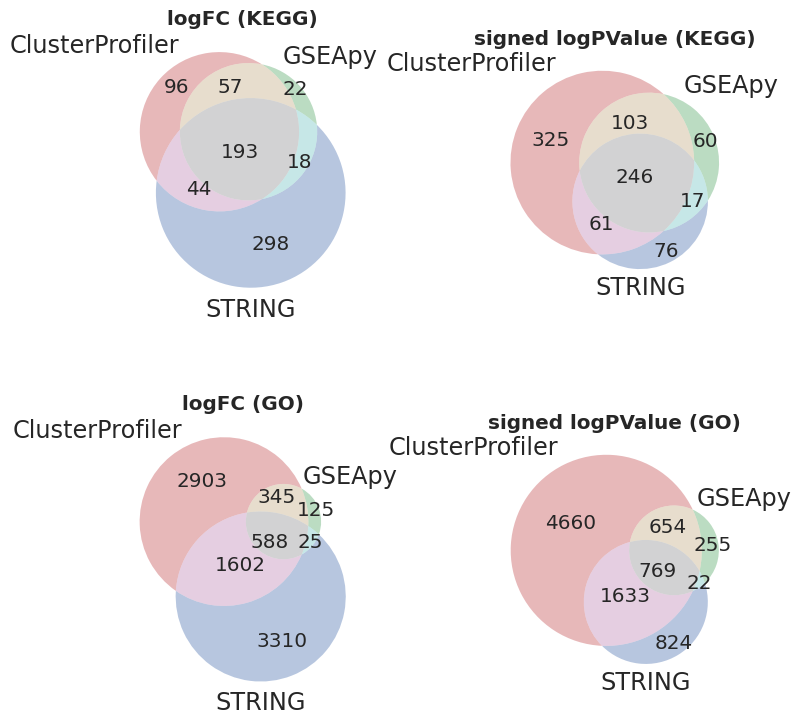

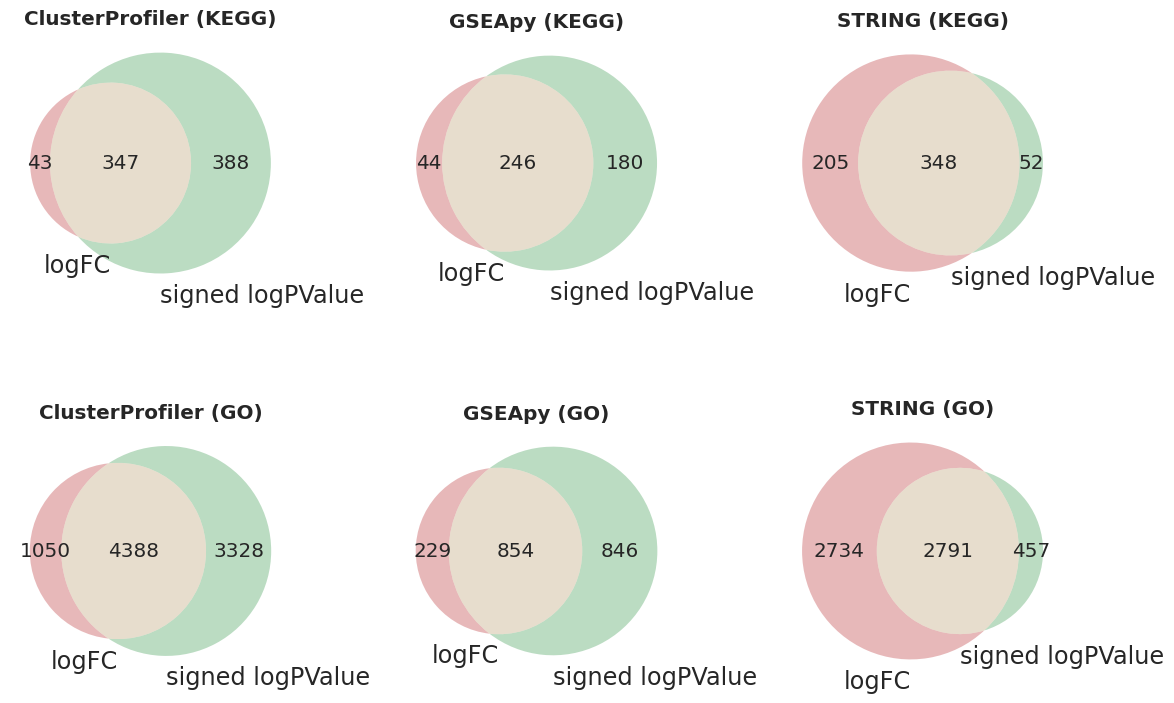

In [ ]:
from scripts.plots import plot_venn

fig, ax = plt.subplots(2, 2, figsize=(8,8))

for i, lib in enumerate(libraries):
    summary_df = meta_summary_dict[lib]
    sig_dict = get_sig_dict(summary_df, tools, metrics, qval=0.05)
    for j, metric in enumerate(metrics):
        plot_venn(sig_dict, tools, metric, ax[i][j], pretty_print)
        ax[i][j].set_title(f"{pretty_print[metric]} ({lib})", fontweight='bold')

fig.tight_layout()
fig.savefig("../../results/meta/venn.methodcomp.meta.pdf")


fig, ax = plt.subplots(2, 3, figsize=(12,8))

for i, lib in enumerate(libraries):
    summary_df = meta_summary_dict[lib]
    sig_dict = get_sig_dict(summary_df, tools, metrics, qval=0.05)
    for j, tool in enumerate(tools):
        plot_venn(sig_dict, tool, metrics, ax[i][j], pretty_print)
        ax[i][j].set_title(f"{pretty_print[tool]} ({lib})", fontweight='bold')

fig.tight_layout()
fig.savefig("../../results/meta/venn.metriccomp.meta.pdf")

/home/peter/miniforge3/envs/SynEnrich/lib/python3.12/site-packages/upsetplot/data.py:303: FutureWarning: Downcasting object dtype arrays on .fillna, .ffill, .bfill is deprecated and will change in a future version. Call result.infer_objects(copy=False) instead. To opt-in to the future behavior, set `pd.set_option('future.no_silent_downcasting', True)`
  df.fillna(False, inplace=True)
/home/peter/miniforge3/envs/SynEnrich/lib/python3.12/site-packages/upsetplot/plotting.py:795: FutureWarning: A value is trying to be set on a copy of a DataFrame or Series through chained assignment using an inplace method.
The behavior will change in pandas 3.0. This inplace method will never work because the intermediate object on which we are setting values always behaves as a copy.

For example, when doing 'df[col].method(value, inplace=True)', try using 'df.method({col: value}, inplace=True)' or df[col] = df[col].method(value) instead, to perform the operation inplace on the original object.


  style

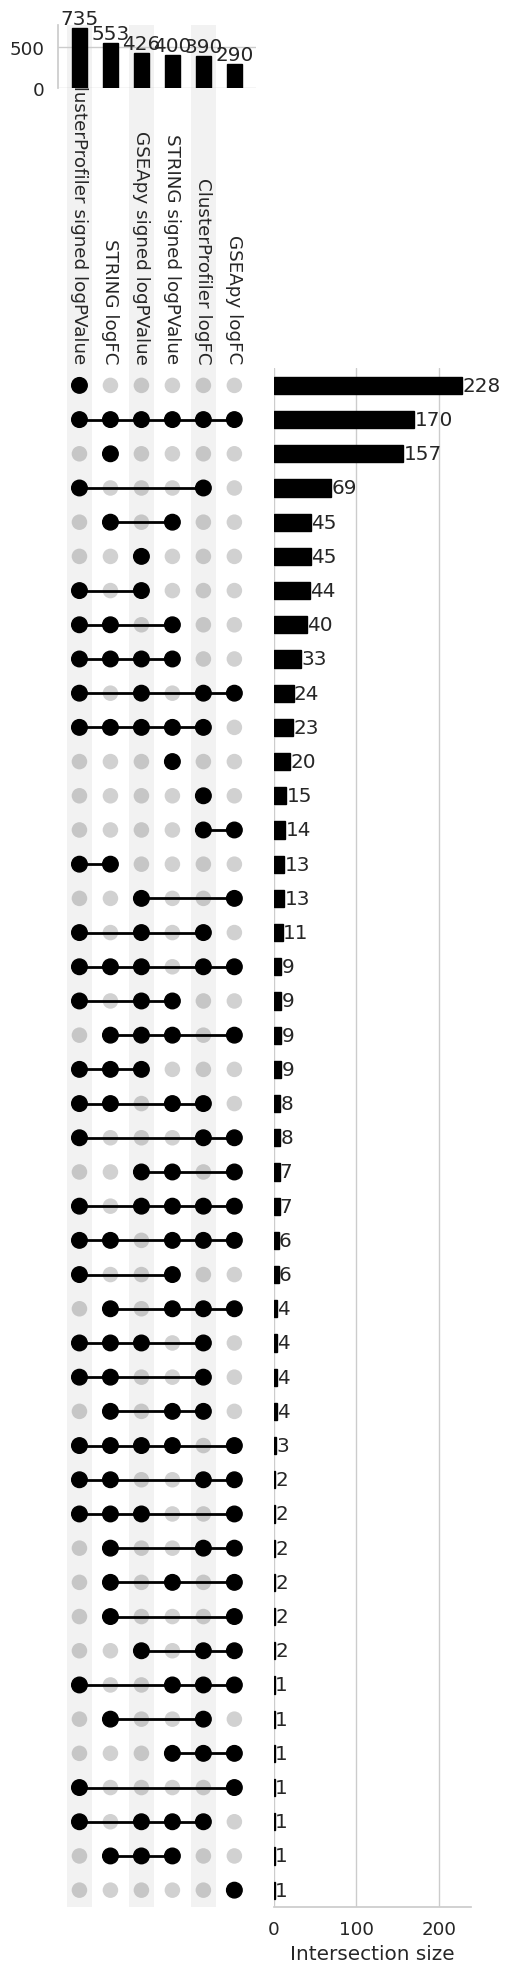

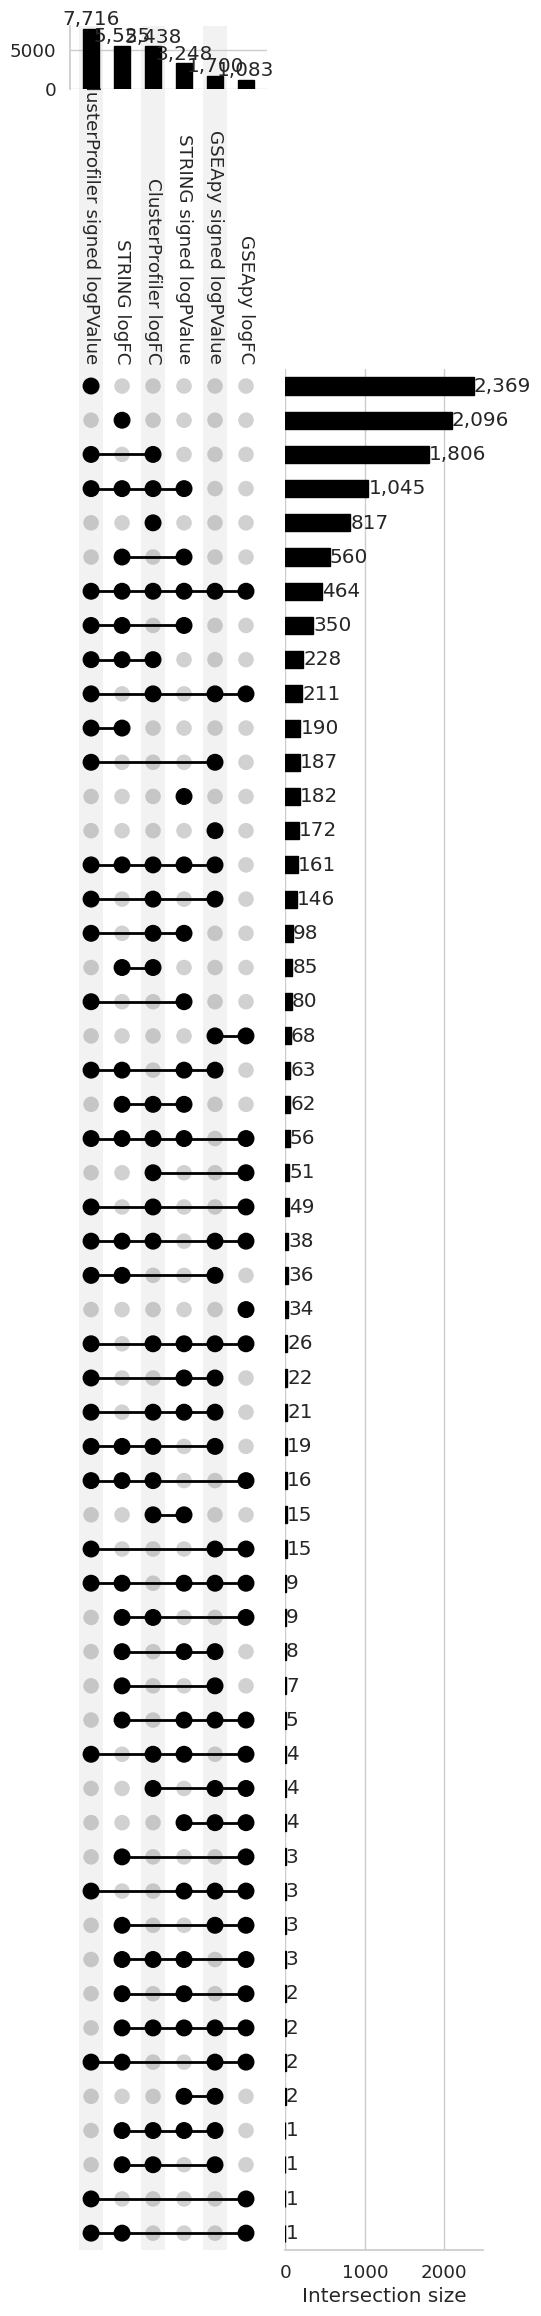

In [ ]:
from matplotlib import pyplot
from upsetplot import from_memberships, UpSet

for lib in libraries:

    depth_df = meta_depth_dict[lib]
    memberships = depth_df["Factors"]
    memberships_list = [categories.split(" | ") for categories in memberships.values]
    upset_ready = from_memberships(memberships_list)
    upset_ready.index.names = [" ".join([pretty_print[i] for i in u.split(".")]) for u in upset_ready.index.names] # pretty print

    pd.options.mode.copy_on_write = False
    UpSet(upset_ready, subset_size="count", sort_by="cardinality", show_counts="{:,}", orientation="vertical").plot()
    pd.options.mode.copy_on_write = True
    pyplot.savefig(f"../../results/meta/upset.{lib}.meta.pdf", bbox_inches='tight')

<Figure size 640x480 with 0 Axes>

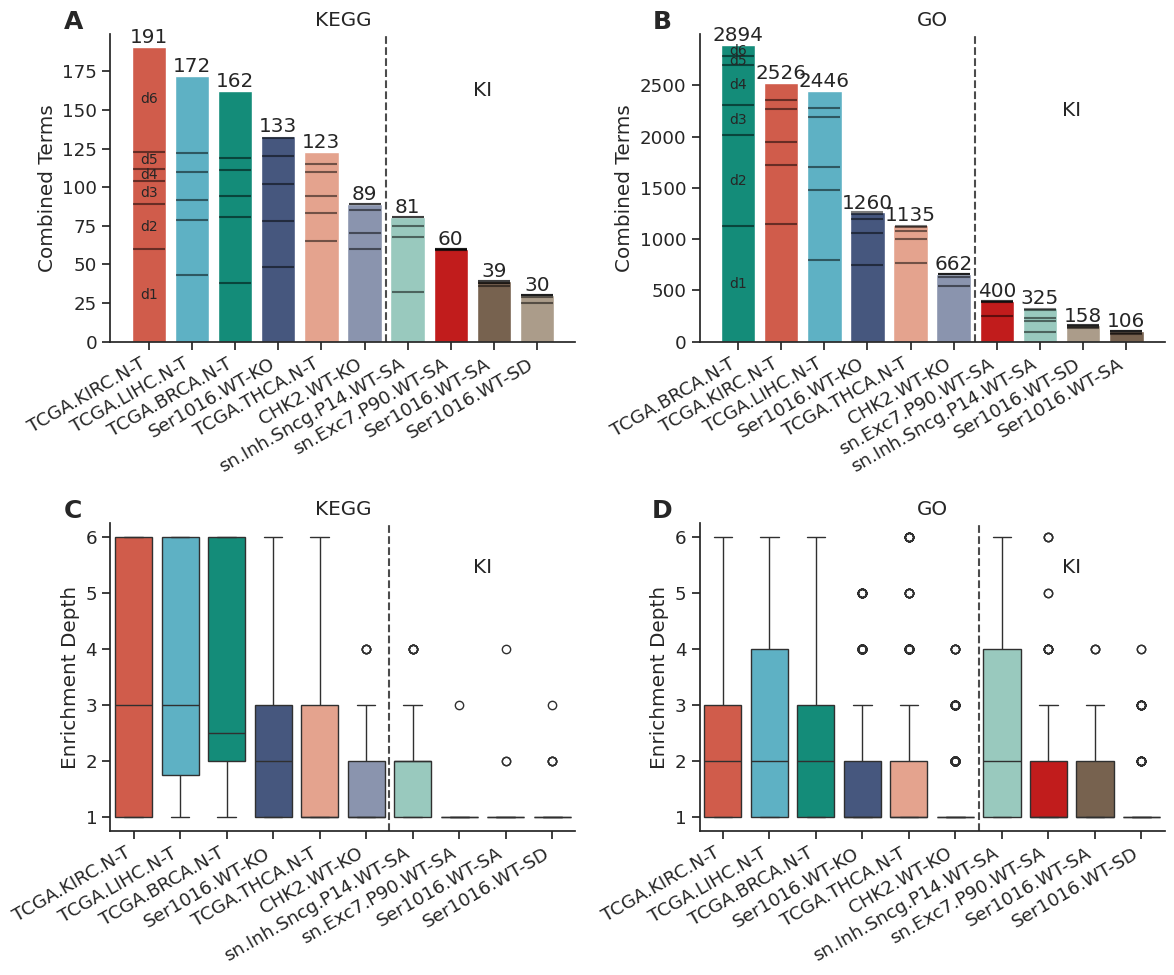

In [430]:
sns.set(font_scale=1.2)
sns.set_style("whitegrid")
sns.set_style("ticks")
sns.despine()

fig, axes = plt.subplots(2, 2, figsize=(12,10))
axes = axes.flatten()

### Number of terms per dataset

for ax, lib in zip(axes[:2],libraries):
    sns.despine()
    depth_df = meta_depth_dict[lib]
    depth_df.replace({"Project":pretty_datanames}, inplace=True)

    counts = depth_df.groupby(["Project"]).count()["Factors"].sort_values(ascending=False)

    counts = pd.DataFrame(counts)

    counts["hue"] = counts.index
    #counts.replace({"hue":pretty_datanames}, inplace=True)

    if ax == axes[0]:
        hue_order = {counts.iloc[i]["hue"]: npg[i] for i in range(len(counts))}
        
    b = sns.barplot(data=counts, y="Factors", x="hue", ax=ax, hue="hue", hue_order=hue_order, palette=npg[:len(project_names)])
    ax.set(title=lib,xlabel=None,ylabel="Combined Terms")

    for i in b.containers:
        b.bar_label(i,)

    if ax == axes[1]:
        ax.set_ylim(0,2999)
    
    if ax == axes[0]:
        ax.set_ylim(0,199)

    # mark depths with horzontal lines
    g = depth_df.groupby(["Project"])["Depth"].value_counts()
    for j, p in enumerate(counts.index):
        sum = 0
        prev_sum = 0
        maxdepth = g.index.get_level_values("Depth").max()
        for i in range(1,1+maxdepth):
            try:
                sum += g.loc[(p,i)]
            except KeyError:
                pass
            if i < maxdepth:
                ax.scatter(j, sum, marker="_", color="black", s=550, alpha=0.5)
            if j == 0:
                ax.text(s=f"d{i}",x=j,y=prev_sum + 0.5*(sum-prev_sum), ha="center", va="center",fontsize=10)
            prev_sum = sum

for ax, lib in zip(axes[2:], libraries):
    depth_df = meta_depth_dict[lib]
    #depth_df.replace({"Project":pretty_datanames}, inplace=True)
    #sns.barplot(data=depth_df, x="Project", y="Depth", hue="Project", errorbar="sd", ax=ax, order=hue_order.keys(), hue_order=hue_order, palette=npg[:len(project_names)])
    sns.boxplot(data=depth_df, x="Project", y="Depth", hue="Project", ax=ax, order=hue_order.keys(), hue_order=hue_order, palette=npg[:len(project_names)])
    ax.set(ylabel="Enrichment Depth",title=lib)

    if ax == axes[3]:
        ax.set_ylim(axes[2].get_ylim())

for i in range(len(axes)):
    axes[i].annotate(chr(ord('A')+i), xy=(-0.08, 1.04), xycoords="axes fraction", weight="bold", va='center',ha='center', fontsize=18)
    axes[i].set_xticks(axes[i].get_xticks(), axes[i].get_xticklabels(), rotation=30, ha='right')
    axes[i].set(xlabel=None)

    # annotate KI
    axes[i].axvline(len(pretty_datanames)-4.5,0,axes[i].get_ylim()[1],ls="--",color="black",alpha=0.7)
    #axes[i].annotate("KI", xy=(0,0), xytext=(len(pretty_datanames)-3, 0.8*axes[i].get_ylim()[1] ), xycoords="data",zorder=99)

    if i == 0:
        axes[i].annotate("KI", xy=(0,0), xytext=(0.78,0.8), xycoords="axes fraction",zorder=99)
    elif i == 1:
        axes[i].annotate("KI", xy=(0,0), xytext=(0.78,0.735), xycoords="axes fraction",zorder=99)
    elif i == 2:
        axes[i].annotate("KI", xy=(0,0), xytext=(0.78,0.84), xycoords="axes fraction",zorder=99)
    else:
        axes[i].annotate("KI", xy=(0,0), xytext=(0.78,0.84), xycoords="axes fraction",zorder=99)

fig.tight_layout()
fig.savefig("../../results/meta/bars.data.meta.pdf")

In [312]:
# LaTeX

basestring = '''\\begin{figure}[!htb]
\centering
\includegraphics[width=1\\textwidth]{Figures/SynEnrich/Supplement/bars.BLANK.pdf}
%\decoRule
\caption[Depth and number of enriched terms (PRETTYNAME).]{\\textbf{Intersection depth and number of enriched terms per configuration (PRETTYNAME).} Top row: Intersection depth of all significant KEGG and GO terms. Bottom row: Number of significant terms for each configuration.}
\label{fig:res:enrich:bars.BLANK}
\end{figure}

\\begin{figure}[!htb]
\centering
\includegraphics[width=0.8\\textwidth]{Figures/SynEnrich/Supplement/venn.methodcomp.BLANK.pdf}
%\decoRule
\caption[Venn diagrams of enrichment methods (PRETTYNAME).]{\\textbf{Venn diagrams comparing results from different enrichment tools (PRETTYNAME).}}
\label{fig:res:enrich:venn3:BLANK}
\end{figure}

\\begin{figure}[!htb]
\centering
\includegraphics[width=1\\textwidth]{Figures/SynEnrich/Supplement/venn.metriccomp.BLANK.pdf}
%\decoRule
\caption[Venn diagrams of ranking metrics (PRETTYNAME).]{\\textbf{Venn diagrams comparing results from different ranking metrics (PRETTYNAME).} }
\label{fig:res:enrich:venn2:BLANK}
\end{figure}

'''

finalstring = ''''''

for name, prettyname in pretty_datanames.items():
    finalstring += basestring.replace("BLANK",name).replace("PRETTYNAME",prettyname)

print(finalstring)

\begin{figure}[!htb]
\centering
\includegraphics[width=1\textwidth]{Figures/SynEnrich/Supplement/bars.BRCA.QLF.pdf}
%\decoRule
\caption[Depth and number of enriched terms (TCGA.BRCA.N-T).]{\textbf{Intersection depth and number of enriched terms per configuration (TCGA.BRCA.N-T).} Top row: Intersection depth of all significant KEGG and GO terms. Bottom row: Number of significant terms for each configuration.}
\label{fig:res:enrich:bars.BRCA.QLF}
\end{figure}

\begin{figure}[!htb]
\centering
\includegraphics[width=0.8\textwidth]{Figures/SynEnrich/Supplement/venn.methodcomp.BRCA.QLF.pdf}
%\decoRule
\caption[Venn diagrams of enrichment methods (TCGA.BRCA.N-T).]{\textbf{Venn diagrams comparing results from different enrichment tools (TCGA.BRCA.N-T).}}
\label{fig:res:enrich:venn3:BRCA.QLF}
\end{figure}

\begin{figure}[!htb]
\centering
\includegraphics[width=1\textwidth]{Figures/SynEnrich/Supplement/venn.metriccomp.BRCA.QLF.pdf}
%\decoRule
\caption[Venn diagrams of ranking metrics (TCGA.BRCA.

<>:3: SyntaxWarning: invalid escape sequence '\c'
<>:3: SyntaxWarning: invalid escape sequence '\c'
/tmp/ipykernel_6676/1560385318.py:3: SyntaxWarning: invalid escape sequence '\c'
  basestring = '''\\begin{figure}[!htb]


# Format STRING table

User can (optionally) manually add STRING functional scoring output tables to the results folder, and they will be combined with the output from SynEnrich. For this, STRING tables have to be formatted first.

In [95]:
from scripts.utils import format_string_table

string_file1 = f"{savepath}/syn.string.logFC.{project_name}.tsv"
string_file2 = f"{savepath}/syn.string.neg_signed_logpval.{project_name}.tsv"

for string_file in [string_file1, string_file2]:

    string = pd.read_csv(string_file, index_col=0, sep="\t")

    for library in ["GO", "KEGG"]:
        string_formatted = format_string_table(string, library)
        display(string_formatted.head())
        string_formatted.to_csv(string_file.replace(f"{project_name}.tsv", f"{library}.{project_name}.csv"))

,Description,genes mapped,enrichmentScore,direction,qvalue,method,matching proteins in your input (IDs),matching proteins in your input (labels),ONTOLOGY,pvalue
ID,,,,,,,,,,
GO:0009063,Cellular amino acid catabolic process,103,-1.205760,top,3.100000e-20,ks,"9606.ENSP00000039007,9606.ENSP00000168216,9606...","OTC,HSD17B10,DLD,AHCY,CRYM,DAO,AGXT2,GOT2,CDO1...",BP,3.100000e-20
GO:0006959,Humoral immune response,146,-1.237910,top,2.500000e-16,ks,"9606.ENSP00000164227,9606.ENSP00000169298,9606...","BCL3,ST6GAL1,CCL22,EBI3,C5,BLNK,C1QBP,CCL2,CXC...",BP,2.500000e-16
GO:0006956,Complement activation,49,-2.063830,top,3.550000e-16,ks,"9606.ENSP00000223642,9606.ENSP00000225698,9606...","C5,C1QBP,C4BPB,C3,CFP,CFHR5,C9,C6,C1RL,FCN3,SE...",BP,3.550000e-16
GO:0072329,Monocarboxylic acid catabolic process,99,-0.944170,top,3.550000e-16,ks,"9606.ENSP00000001146,9606.ENSP00000168216,9606...","CYP26B1,HSD17B10,XYLB,PCK2,ACOT8,ABCD1,PLA2G15...",BP,3.550000e-16
GO:1901605,Alpha-amino acid metabolic process,177,-0.902143,top,3.550000e-16,ks,"9606.ENSP00000039007,9606.ENSP00000040663,9606...","OTC,MRI1,HSD17B10,SIRT4,AHCY,CRYM,PYCR3,PLOD3,...",BP,3.550000e-16


,Description,genes mapped,enrichmentScore,direction,qvalue,method,matching proteins in your input (IDs),matching proteins in your input (labels),ONTOLOGY,pvalue
ID,,,,,,,,,,
hsa04610,Complement and coagulation cascades,79,-1.138660,top,7.740000e-22,ks,"9606.ENSP00000181383,9606.ENSP00000215727,9606...","CPB2,SERPIND1,PROCR,F9,PLAT,SERPINE1,C5,VTN,TF...",KEGG,7.740000e-22
hsa04060,Cytokine-cytokine receptor interaction,157,-0.886873,top,8.800000e-18,ks,"9606.ENSP00000006053,9606.ENSP00000011653,9606...","CX3CL1,CD4,RELT,TNFRSF1A,NGFR,OSM,IL2RB,CCL22,...",KEGG,8.800000e-18
hsa00830,Retinol metabolism,50,-2.142700,top,2.390000e-14,ks,"9606.ENSP00000001146,9606.ENSP00000209668,9606...","CYP26B1,ADH1A,CYP3A5,CYP26A1,RDH10,ALDH1A2,UGT...",KEGG,2.390000e-14
hsa00982,Drug metabolism - cytochrome P450,52,-1.681700,top,3.590000e-13,ks,"9606.ENSP00000209668,9606.ENSP00000209929,9606...","ADH1A,FMO2,CYP3A5,GSTM2,UGT2A3,FMO5,GSTM5,CYP2...",KEGG,3.590000e-13
hsa05150,Staphylococcus aureus infection,50,-1.134990,top,5.790000e-12,ks,"9606.ENSP00000209718,9606.ENSP00000223642,9606...","KRT23,C5,SELPLG,HLA-DOA,C3,DSG1,SELP,ICAM1,KRT...",KEGG,5.790000e-12


,Description,genes mapped,enrichmentScore,direction,qvalue,method,matching proteins in your input (IDs),matching proteins in your input (labels),ONTOLOGY,pvalue
ID,,,,,,,,,,
GO:0009063,Cellular amino acid catabolic process,103,-2.22237,top,2.460000e-21,ks,"9606.ENSP00000039007,9606.ENSP00000168216,9606...","OTC,HSD17B10,DLD,AHCY,CRYM,DAO,AGXT2,GOT2,CDO1...",BP,2.460000e-21
GO:0098813,Nuclear chromosome segregation,179,2.62232,bottom,3.340000e-17,ks,"9606.ENSP00000160827,9606.ENSP00000166345,9606...","KIF22,TRIP13,ZW10,CHMP4B,STAG2,CHMP5,MLH1,VPS4...",BP,3.340000e-17
GO:0006260,DNA replication,192,2.04835,bottom,2.220000e-16,ks,"9606.ENSP00000023939,9606.ENSP00000040738,9606...","RTF2,BOD1L1,RFC2,CDC6,CDC34,MCM5,SUPT16H,POLE2...",BP,2.220000e-16
GO:1901605,Alpha-amino acid metabolic process,177,-1.48346,top,2.530000e-16,ks,"9606.ENSP00000039007,9606.ENSP00000040663,9606...","OTC,MRI1,HSD17B10,SIRT4,AHCY,CRYM,PYCR3,PLOD3,...",BP,2.530000e-16
GO:0072329,Monocarboxylic acid catabolic process,99,-2.23570,top,2.160000e-15,ks,"9606.ENSP00000001146,9606.ENSP00000168216,9606...","CYP26B1,HSD17B10,XYLB,PCK2,ACOT8,ABCD1,PLA2G15...",BP,2.160000e-15


,Description,genes mapped,enrichmentScore,direction,qvalue,method,matching proteins in your input (IDs),matching proteins in your input (labels),ONTOLOGY,pvalue
ID,,,,,,,,,,
hsa04610,Complement and coagulation cascades,79,-1.79817,top,1.020000e-14,ks,"9606.ENSP00000181383,9606.ENSP00000215727,9606...","CPB2,SERPIND1,PROCR,F9,PLAT,SERPINE1,C5,VTN,TF...",KEGG,1.020000e-14
hsa04060,Cytokine-cytokine receptor interaction,157,-1.56994,top,1.430000e-13,ks,"9606.ENSP00000006053,9606.ENSP00000011653,9606...","CX3CL1,CD4,RELT,TNFRSF1A,NGFR,OSM,IL2RB,CCL22,...",KEGG,1.430000e-13
hsa00830,Retinol metabolism,50,-2.44117,top,1.020000e-10,ks,"9606.ENSP00000001146,9606.ENSP00000209668,9606...","CYP26B1,ADH1A,CYP3A5,CYP26A1,RDH10,ALDH1A2,UGT...",KEGG,1.020000e-10
hsa00280,"Valine, leucine and isoleucine degradation",44,-2.65469,top,1.850000e-10,ks,"9606.ENSP00000168216,9606.ENSP00000196371,9606...","HSD17B10,OXCT1,DLD,AGXT2,EHHADH,ACADS,MCEE,ALD...",KEGG,1.850000e-10
hsa00071,Fatty acid degradation,39,-2.75978,top,7.530000e-10,ks,"9606.ENSP00000209668,9606.ENSP00000231887,9606...","ADH1A,EHHADH,ACADL,ACADS,ALDH2,CPT1A,ACAT1,ACA...",KEGG,7.530000e-10


# Test stuff

## ClusterProfiler

In [ ]:
%load_ext rpy2.ipython

In [ ]:
%%R
source("../../.Rprofile")
.libPaths()

In [ ]:
%%R -i input_file
library(clusterProfiler)
library(org.Hs.eg.db)

In [ ]:
%%R

filepath <- paste0("../../",input_file)

metrics = c("neg_signed_logpval","logFC")

df <- read.csv(filepath, row.names = 1)

for (metric in metrics) {
    # Check if the metric is in the columns
    if (!(metric %in% colnames(df))) {
            if (metric == "neg_signed_logpval") {
                message(paste("Adding", metric, "to df"))
                df$neg_signed_logpval <- -sign(df$logFC) * log10(df$PValue)
            } else {
                stop(paste("Metric", metric, "not in columns!"))
            }
        }
}

head(df)

In [ ]:
%%R

run_clusterProfiler <- function(df, savepath, paramset,
                                metric, cluster, overwrite=FALSE, 
                                organism.KEGG="hsa",
                                organism.GO = org.Hs.eg.db, seed=123) 
{
  set.seed(seed)

  outfile_go <- paste0(savepath,"/cluster.gseGO.",metric,".",paramset,".csv")
  outfile_kegg <- paste0(savepath,"/cluster.gseKEGG.",metric,".",paramset,".csv")
  print(outfile_go)
  print(outfile_kegg)

  if (file.exists(outfile_go) && file.exists(outfile_kegg) && !overwrite) {
    print("Existing files not overwritte, skipping")
    return
  }

  start_time <- Sys.time()

  geneList <- df[[metric]]
  names(geneList) <- df$ENTREZID
  geneList = sort(geneList, decreasing = TRUE)

  if (!file.exists(outfile_go) || overwrite) {

    ego3 <- gseGO(geneList     = geneList,
                  OrgDb        = organism.GO,
                  ont          = "ALL", ## CC MF BP
                  minGSSize    = 10,
                  maxGSSize    = 500,
                  pvalueCutoff = 1,
                  eps = 0,
                  seed = TRUE,
                  verbose = FALSE)
    write.csv(ego3,outfile_go)
  }

  if (!file.exists(outfile_kegg) || overwrite) {

    kegg <- gseKEGG(geneList     = geneList,
                  organism        =  organism.KEGG,
                  minGSSize    = 10,
                  maxGSSize    = 500,
                  pvalueCutoff = 1,
                  eps = 0,
                  seed = TRUE,
                  verbose = FALSE)
    write.csv(kegg,outfile_kegg)
  }

  end_time <- Sys.time()
  print(end_time - start_time)
}

convert_df <- function(df, OrgDb=org.Hs.eg.db) {

  if ("ENTREZID" %in% names(df)) return(df)
  
  df$ENSEMBL <- row.names(df)
  # Convert to ENTREZ ID
  # We will lose some genes here because not all IDs will be converted

  ids<-bitr(row.names(df), fromType = "ENSEMBL", toType = "ENTREZID", OrgDb=OrgDb)
  df <- merge(df, ids, by = "ENSEMBL", all.x = TRUE)
  print(paste("Before",nrow(df)))
  df <- na.omit(df)
  print(paste("After",nrow(df)))
  return(df)
}

In [ ]:
%%R
df <- convert_df(df, OrgDb=org.Hs.eg.db)
head(df)

In [ ]:
%%R -i project_name
savepath <- paste0("../../results/",project_name)
paramset <- "test"
metric <- "neg_signed_logpval"
df <- convert_df(df, OrgDb=org.Hs.eg.db)
run_clusterProfiler(df, savepath, paramset,
                                metric, overwrite=FALSE, 
                                organism.KEGG="hsa",
                                organism.GO = org.Hs.eg.db) 